In [103]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import requests

base_url = "http://localhost:8888/files"
token = "96b93bbc6a79d96d1b473f5d216b4c5439e21833db49cdaa"

start_date = "2023-03-01"
end_date = "2023-09-01"

visit_path = f"https://data-charts-api.hexlet.app/visits?begin={start_date}&end={end_date}"
registration_path= f"https://data-charts-api.hexlet.app/registrations?begin={start_date}&end={end_date}"

visit = requests.get(visit_path).json()
reg = requests.get(registration_path).json()

visits_df = pd.DataFrame(data = visit)
registrations_df = pd.DataFrame(data = reg)

print(visits_df)
print(registrations_df)

ads_path = "data-analytics-project-100/ads.csv"

def load_data(path):
    url = f"{base_url}/{path}?token={token}&start_date={start_date}&end_date={end_date}"
    response = requests.get(url)
    if response.status_code == 200:
        return pd.read_csv(pd.io.common.BytesIO(response.content))
    else:
        raise ValueError(f"Ошибка загрузки данных из {path}")
        
ads_df = load_data(ads_path)
ads_df['date'] = pd.to_datetime(ads_df['date']).dt.date


print("REKLAMA",ads_df)

                                    visit_id platform  \
0       1de9ea66-70d3-4a1f-8735-df5ef7697fb9      web   
1       f149f542-e935-4870-9734-6b4501eaf614      web   
2       08f0ebd4-950c-4dd9-8e97-b5bdf073eed1      web   
3       19322fed-157c-49c6-b16e-2d5cabeb9592      web   
4       04762a22-3c9f-40c9-9ac9-6628c4381836      web   
...                                      ...      ...   
263454  6d2e2f5b-970b-4dfe-8f57-25711a5b2a5d      web   
263455  1d91535e-d984-4f76-bbaa-c14c0fd4f2e2      web   
263456  f2496721-7126-430d-976e-777a6cdccb4f      web   
263457  f2496721-7126-430d-976e-777a6cdccb4f      web   
263458  73047125-de44-4d65-8229-7218acff4ddc      web   

                                               user_agent             datetime  
0       Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...  2023-03-01T10:36:22  
1       Mozilla/5.0 (Windows NT 10.0; WOW64; Trident/7...  2023-03-01T06:25:00  
2       Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...  2023-03-01T10

In [117]:
print("Визиты: ")
print(visits_df.describe())
print("\n Регистрация: ")
print(registrations_df.describe())
print("\n Реклама: ")
print(ads_df.describe())
#последний визит - уникальный!!!!

visits_df['datetime'] = pd.to_datetime(visits_df['datetime'])
registrations_df['datetime'] = pd.to_datetime(registrations_df['datetime']).dt.date
ads_df['date'] = pd.to_datetime(ads_df['date']).dt.date 

# удаление ботов 
visits_df = visits_df[~visits_df['user_agent'].str.contains('bot', case=False, na=False)]
visits_df = visits_df.sort_values(by=['visit_id', 'datetime'], ascending=[True, False])
visits_df = visits_df.drop_duplicates(subset=['visit_id', 'platform'])
visits_df['datetime'] = visits_df['datetime'].dt.date

# агрегация по дате и платформе
# visits_agg = visits_df.groupby(['datetime', 'platform']).agg(visits=('visit_id', 'nunique')).reset_index()
# visits_agg = visits_df.groupby(['datetime', 'platform']).size().reset_index()
visits_agg = visits_df.groupby(['datetime', 'platform']).size().reset_index(name='visits')
# применить drop dublicate sapset
# registrations_agg = registrations_df.groupby(['datetime', 'platform']).agg(registrations=('user_id', 'nunique')).reset_index()

# Оставляем только последнюю регистрацию каждого пользователя
registrations_df = registrations_df.sort_values(by=['datetime']).drop_duplicates(subset=['user_id', 'datetime', 'platform'], keep='last')
registrations_agg = registrations_df.groupby(['datetime', 'platform']).agg(registrations=('user_id', 'count')).reset_index()

# объединение 
conversion_df = pd.merge(visits_agg, registrations_agg, on=['datetime', 'platform'], how='left').fillna(0)
conversion_df['conversion'] = (conversion_df['registrations'] / conversion_df['visits']) * 100

# агрегация по рекламе
ads_agg = ads_df.groupby(['date']).agg(cost=('cost', 'sum'), utm_campaign=('utm_campaign', 'first')).reset_index()

final_df = pd.merge(conversion_df, ads_agg, left_on='datetime', right_on='date', how='left')
final_df['cost'] = final_df['cost'].fillna(0)  # замена NaN на 0 в столбце cost
final_df['utm_campaign'] = final_df['utm_campaign'].fillna('')  # замена NaN на пустую строку в utm_campaign

final_df = final_df.sort_values(by='datetime').reset_index(drop=True)

final_df.to_json('ads.json', orient='columns')
print(final_df.head())


Визиты: 
                                    visit_id platform  \
count                                 138703   138703   
unique                                138703        3   
top     000012d3-f8c7-4257-8999-ad622b703492      web   
freq                                       1   118927   

                                               user_agent    datetime  
count                                              138703      138703  
unique                                                 28         184  
top     Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:109...  2023-03-12  
freq                                                 6845        1394  

 Регистрация: 
          datetime                               user_id               email  \
count        21836                                 21836               21836   
unique         184                                 21836               20868   
top     2023-03-06  2e0f6bb8-b029-4f45-a786-2b53990d37f1  ujones@example.com   
freq     

## Визуализация
### Итоговые визиты

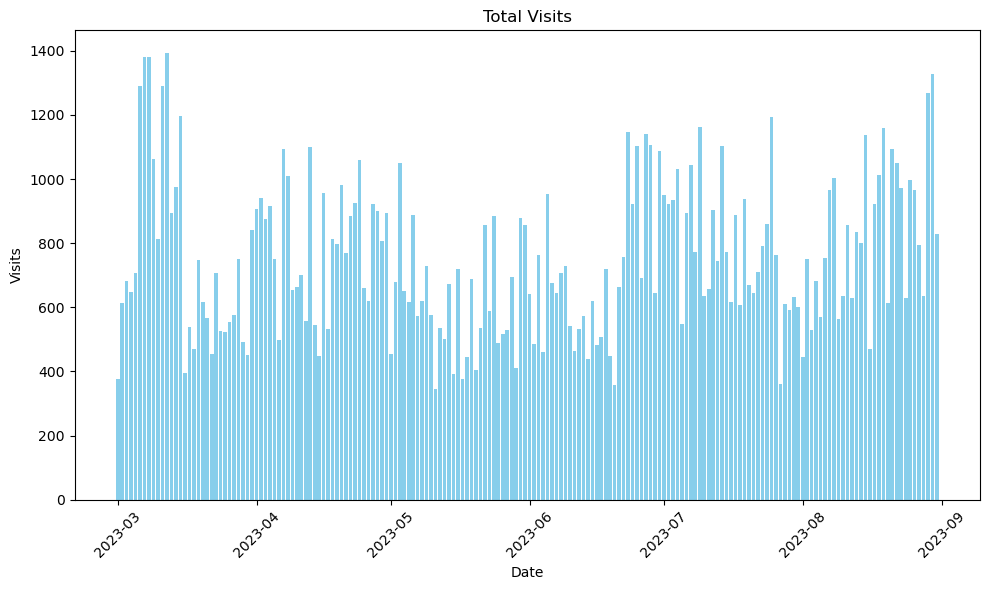

In [119]:
# visits_by_date = visits_df.groupby("date")["uuid"].nunique().reset_index()
visits_by_date = visits_df.groupby("datetime")["visit_id"].nunique().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(visits_by_date["datetime"], visits_by_date["visit_id"], color="skyblue")
plt.xlabel("Date")
plt.ylabel("Visits")
plt.title("Total Visits")
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig("total_visits.png", format="png")
plt.show()


### Итоговые визиты с разбивкой по платформам: web, android, ios

<Figure size 1000x600 with 0 Axes>

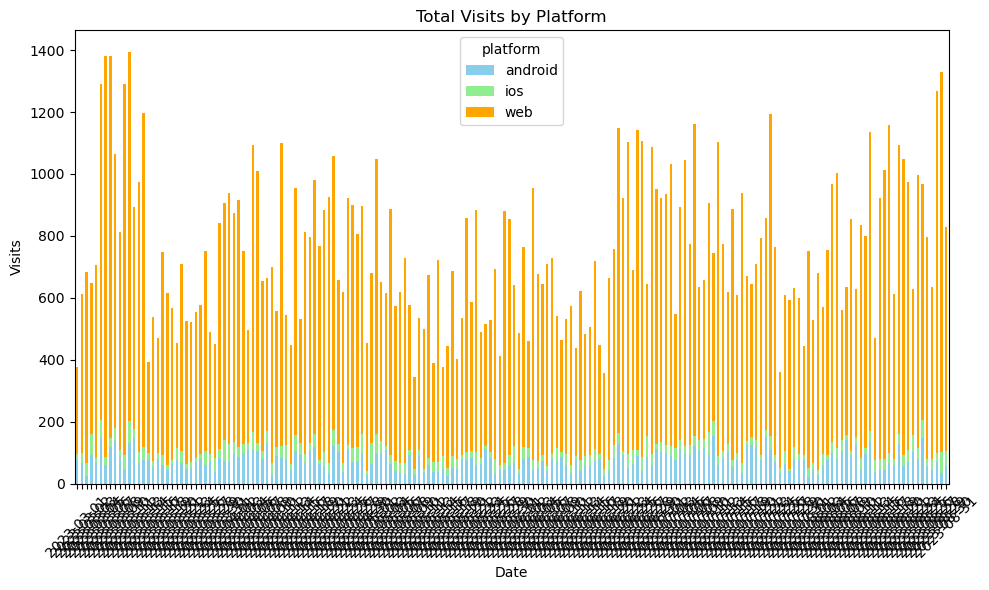

In [113]:
visits_agg = visits_df.groupby(["datetime", "platform"])["visit_id"].count().unstack(fill_value=0)

plt.figure(figsize=(10, 6))
visits_agg.plot(kind="bar", stacked=True, color=["skyblue", "lightgreen", "orange"], figsize=(10, 6))

plt.xlabel("Date")
plt.ylabel("Visits")
plt.title("Total Visits by Platform")
plt.xticks(rotation=45)  
plt.tight_layout()
# plt.savefig("total_visits_stacked.png", format="png") 
plt.show()


### Итоговые регистрации

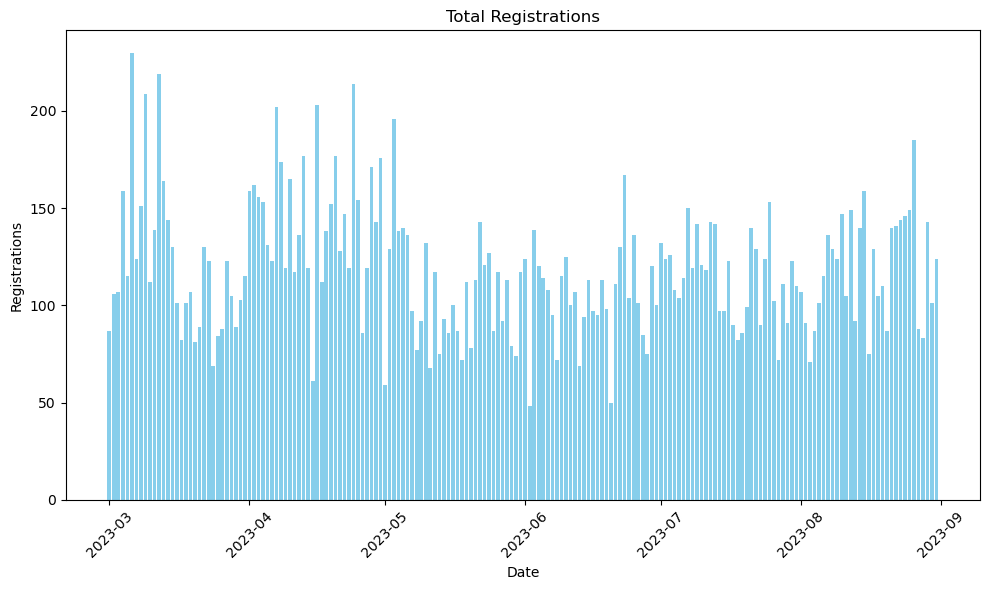

In [121]:
# visits_by_date = visits_df.groupby("date")["uuid"].nunique().reset_index()
registrarion_by_date = registrations_df.groupby("datetime")["user_id"].nunique().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(registrarion_by_date["datetime"], registrarion_by_date["user_id"], color="skyblue")
plt.xlabel("Date")
plt.ylabel("Registration")
plt.title("Total Registrations")
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig("total_registrations.png", format="png")
plt.show()


### Итоговые регистрации с разбивкой по платформе: web, android, ios

<Figure size 1000x600 with 0 Axes>

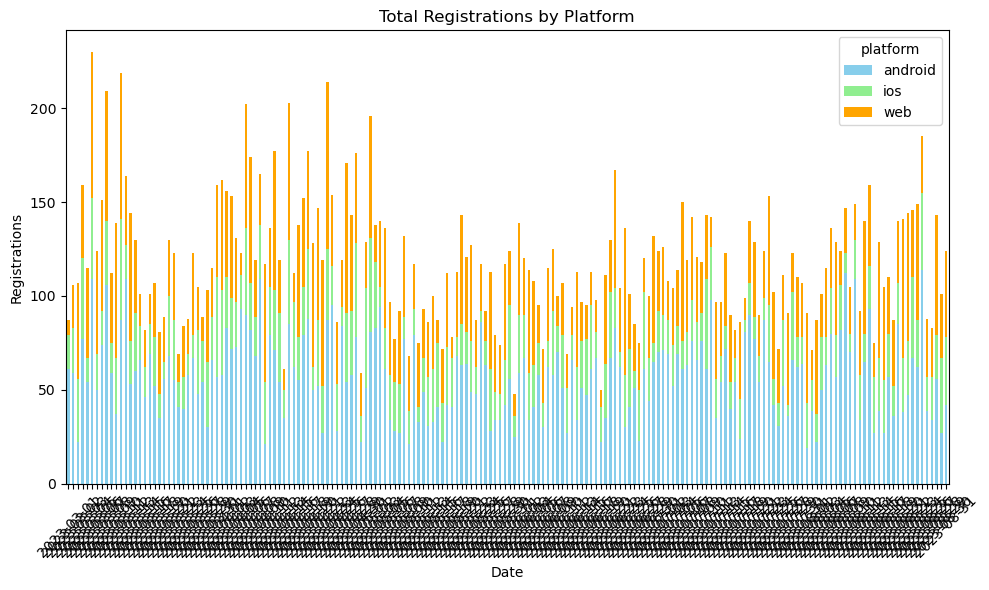

In [122]:
registrations_agg = registrations_df.groupby(["datetime", "platform"])["user_id"].count().unstack(fill_value=0)

plt.figure(figsize=(10, 6))
registrations_agg.plot(kind="bar", stacked=True, color=["skyblue", "lightgreen", "orange"], figsize=(10, 6))

plt.xlabel("Date")
plt.ylabel("Registrations")
plt.title("Total Registrations by Platform")
plt.xticks(rotation=45)  
plt.tight_layout()
# plt.savefig("total_registrations_stacked.png", format="png") 
plt.show()


### Итоговые конверсии

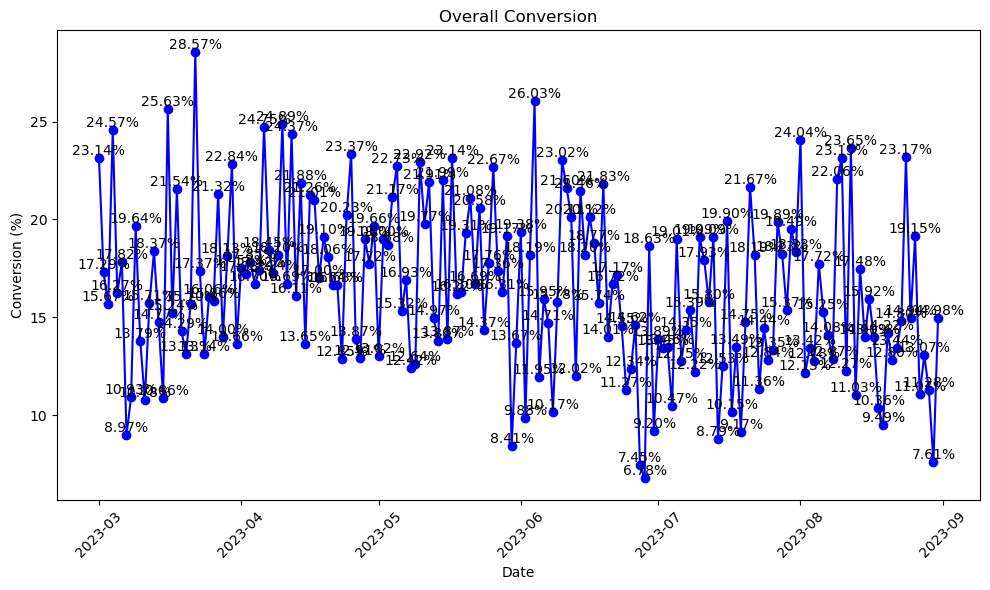

       datetime  visits  registrations  conversion
0    2023-03-01     376             87   23.138298
1    2023-03-02     613            106   17.292007
2    2023-03-03     683            107   15.666179
3    2023-03-04     647            159   24.574961
4    2023-03-05     707            115   16.265912
..          ...     ...            ...         ...
179  2023-08-27     795             88   11.069182
180  2023-08-28     635             83   13.070866
181  2023-08-29    1268            143   11.277603
182  2023-08-30    1328            101    7.605422
183  2023-08-31     828            124   14.975845

[184 rows x 4 columns]


In [114]:
visits_agg = visits_df.groupby("datetime")["visit_id"].count().reset_index(name="visits")
registrations_agg = registrations_df.groupby("datetime")["user_id"].nunique().reset_index(name="registrations")

conversion_df = pd.merge(visits_agg, registrations_agg, on="datetime", how="left")

conversion_df["conversion"] = (conversion_df["registrations"] / conversion_df["visits"]) * 100

plt.figure(figsize=(10, 6))
plt.plot(conversion_df["datetime"], conversion_df["conversion"], marker='o', color='b', label='Conversion Rate')

for i, row in conversion_df.iterrows():
    plt.text(row["datetime"], row["conversion"], f'{row["conversion"]:.2f}%', ha='center', va='bottom')

plt.title("Overall Conversion")
plt.xlabel("Date")
plt.ylabel("Conversion (%)")
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig("conversion_rate_by_date.png", format="png")
plt.show()
print(conversion_df)


### Конверсия по каждой платформе

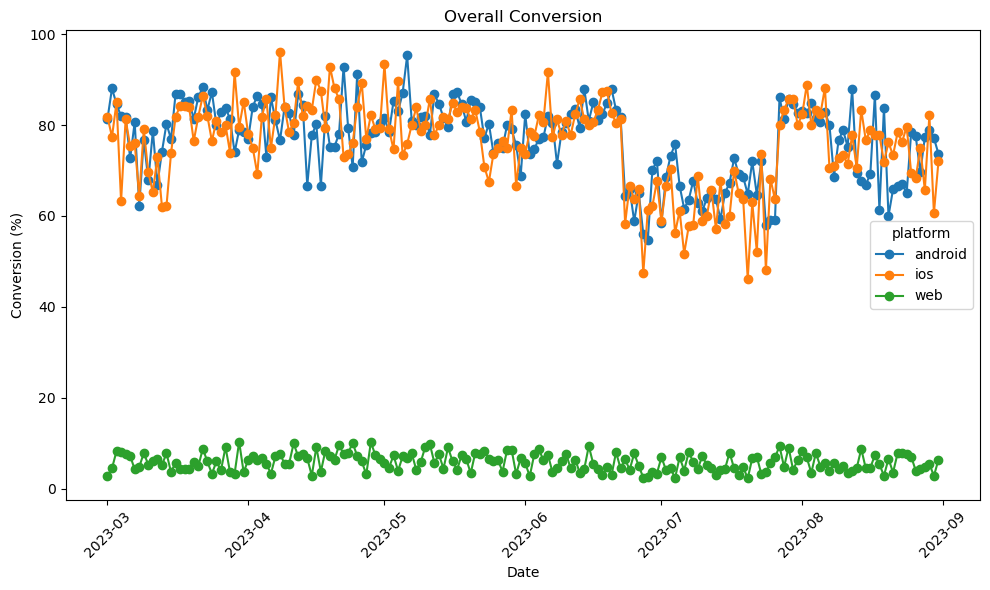

In [116]:
visits_agg = visits_df.groupby(["datetime", "platform"])["visit_id"].count().reset_index(name="visits")
registrations_agg = registrations_df.groupby(["datetime", "platform"])["user_id"].nunique().reset_index(name="registrations")

conversion_df = pd.merge(visits_agg, registrations_agg, on=["datetime", "platform"], how="left")

conversion_df["conversion"] = (conversion_df["registrations"] / conversion_df["visits"]) * 100

# сводная таблица
conversion = conversion_df.pivot_table(values="conversion", index="datetime", columns="platform", aggfunc="mean")

conversion.plot(kind="line", figsize=(10, 6), marker='o', title="Overall Conversion")
plt.xlabel("Date")
plt.ylabel("Conversion (%)")
plt.xticks(rotation=45) 
plt.tight_layout()
# plt.savefig("platform_conversion_rate.png", format="png")  
plt.show()

### Конверсия по каждой платформе

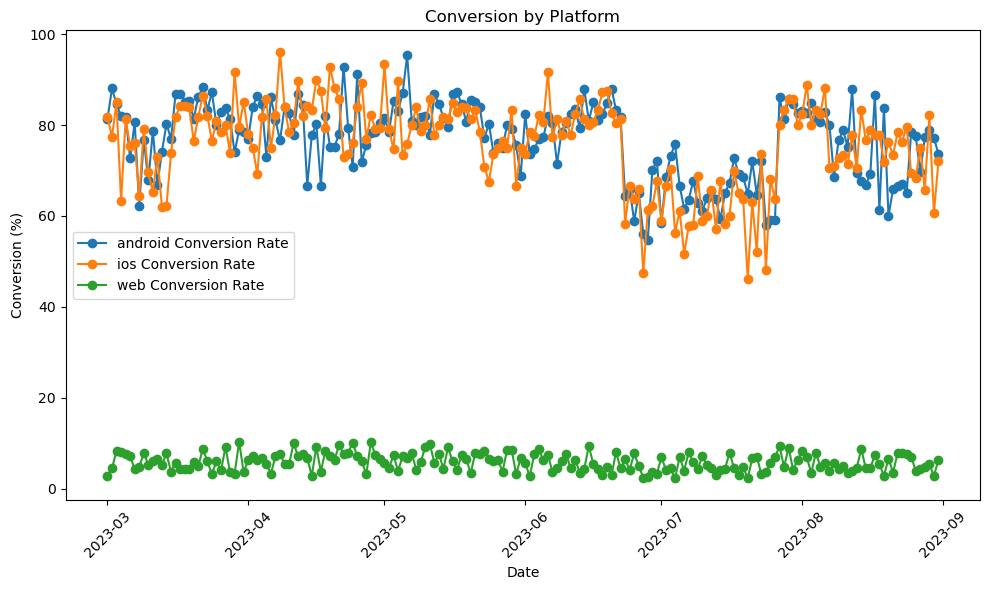

In [123]:
visits_agg_platform = visits_df.groupby(["datetime", "platform"])["visit_id"].count().reset_index(name="visits")
registrations_agg_platform = registrations_df.groupby(["datetime", "platform"])["user_id"].nunique().reset_index(name="registrations")

conversion_df_platform = pd.merge(visits_agg_platform, registrations_agg_platform, on=["datetime", "platform"], how="left")
conversion_df_platform["conversion"] = (conversion_df_platform["registrations"] / conversion_df_platform["visits"]) * 100

plt.figure(figsize=(10, 6))

for platform in conversion_df_platform["platform"].unique():
    platform_data = conversion_df_platform[conversion_df_platform["platform"] == platform]
    plt.plot(platform_data["datetime"], platform_data["conversion"], marker='o', label=f'{platform} Conversion Rate')

plt.title("Conversion by Platform")
plt.xlabel("Date")
plt.ylabel("Conversion (%)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Средняя Конверсия

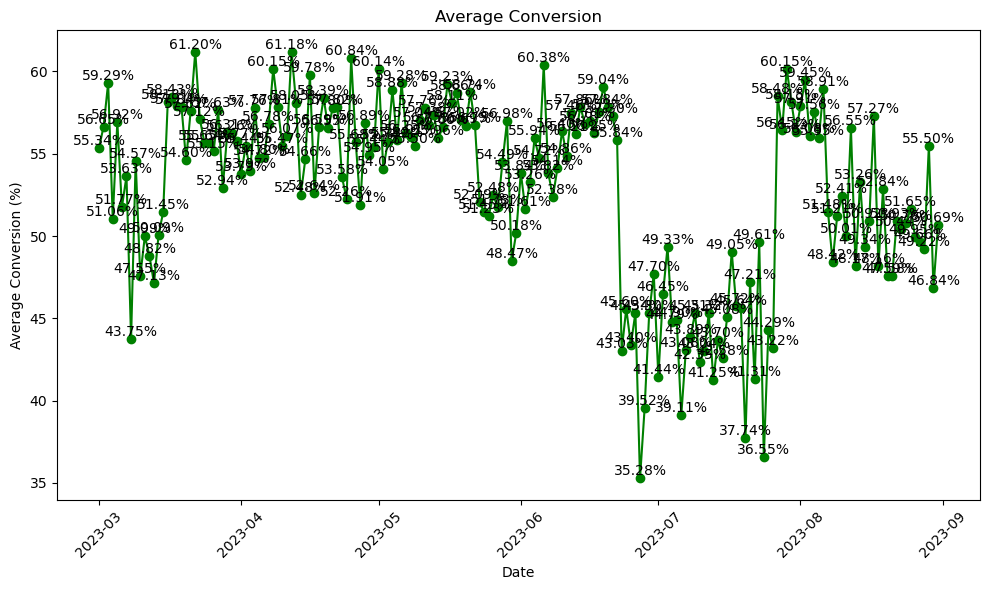

In [124]:
average_conversion = conversion_df_platform.groupby("datetime")["conversion"].mean().reset_index(name="average_conversion")

plt.figure(figsize=(10, 6))
plt.plot(average_conversion["datetime"], average_conversion["average_conversion"], marker='o', color='g', label='Average Conversion Rate')

for i, row in average_conversion.iterrows():
    plt.text(row["datetime"], row["average_conversion"], f'{row["average_conversion"]:.2f}%', ha='center', va='bottom')

plt.title("Average Conversion")
plt.xlabel("Date")
plt.ylabel("Average Conversion (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

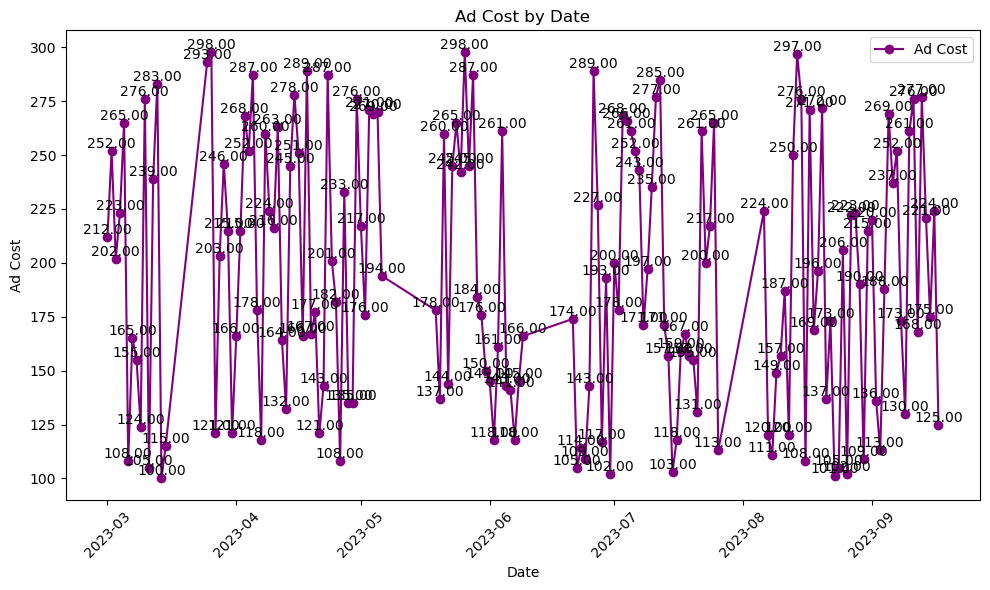

In [125]:
ads_agg = ads_df.groupby("date")["cost"].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(ads_agg["date"], ads_agg["cost"], marker='o', color='purple', label='Ad Cost')

for i, row in ads_agg.iterrows():
    plt.text(row["date"], row["cost"], f'{row["cost"]:.2f}', ha='center', va='bottom')

plt.title("Ad Cost by Date")
plt.xlabel("Date")
plt.ylabel("Ad Cost")
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()
